<a href="https://colab.research.google.com/github/samuelhtampubolon/SDPM2025/blob/main/Time_Series_Regression_Sintetis_TimeSeriesSplit_CV_Fold_RMSE_Prediksi_vs_Aktual_Distribusi_Residual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Validasi deret waktu: TimeSeriesSplit, bandingkan model vs baseline naive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

#  Data sintetis (seed) - trend + musiman + noise
seed = 1234
print("Random seed:", seed)
rng = np.random.default_rng(seed)
n = 1000
t = np.arange(n)
y = 0.5*(t/n) + np.sin(0.05*t) + rng.normal(0, 0.2, size=n)

Random seed: 1234


In [5]:
# Buat fitur lag (tanpa kebocoran)
def make_lagged(y, lags=12):
    X = np.column_stack([np.roll(y, i) for i in range(1, lags+1)])
    X[:lags, :] = np.nan
    return X, y
X_all, y_all = make_lagged(y, lags=12)
mask = ~np.isnan(X_all).any(axis=1)
X_all, y_all = X_all[mask], y_all[mask]

In [6]:
#  TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = Pipeline([("scaler", StandardScaler()),
                  ("ridge", Ridge(alpha=1.0))])

rmse_model, rmse_naive = [], []
fold_idx = -1
for k, (tr, te) in enumerate(tscv.split(X_all)):
    fold_idx = k
    X_tr, X_te = X_all[tr], X_all[te]
    y_tr, y_te = y_all[tr], y_all[te]

    # Baseline naive: y_hat = y(t-1)
    y_hat_naive = X_te[:, 0]
    rmse_naive.append(mean_squared_error(y_te, y_hat_naive)**0.5)

    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)
    rmse_model.append(mean_squared_error(y_te, y_hat)**0.5)

print("Fold RMSE (model):", np.round(rmse_model, 3))
print("Fold RMSE (naive):", np.round(rmse_naive, 3))
print(f"Mean±Std RMSE (model): {np.mean(rmse_model):.3f} ± {np.std(rmse_model):.3f}")

Fold RMSE (model): [0.234 0.223 0.246 0.226 0.24 ]
Fold RMSE (naive): [0.27  0.278 0.311 0.279 0.298]
Mean±Std RMSE (model): 0.234 ± 0.009


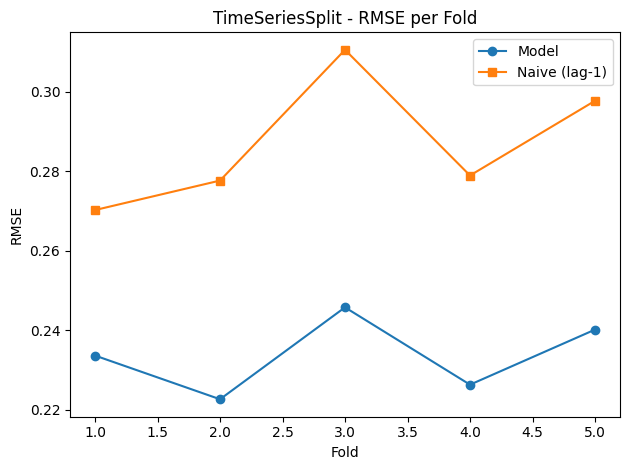

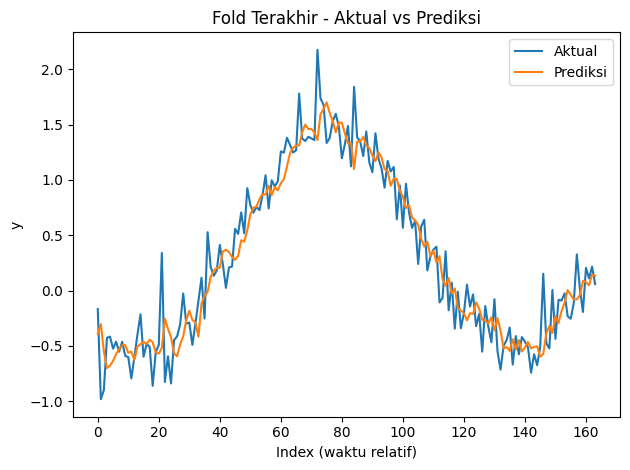

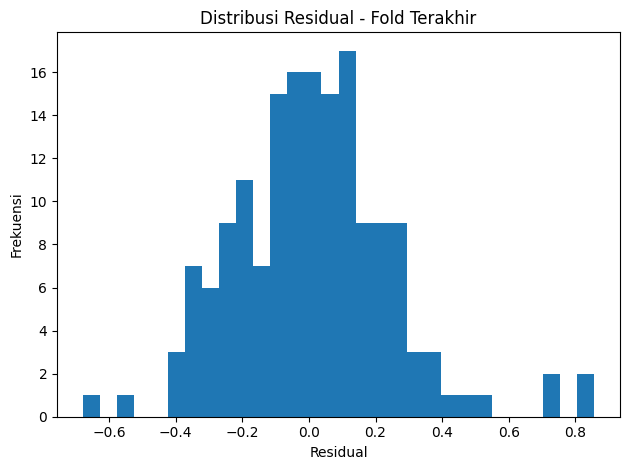

In [7]:
#  Grafik A - RMSE per Fold (model vs naive)
plt.figure()
plt.plot(range(1, len(rmse_model)+1), rmse_model, marker="o", label="Model")
plt.plot(range(1, len(rmse_naive)+1), rmse_naive, marker="s", label="Naive (lag-1)")
plt.xlabel("Fold"); plt.ylabel("RMSE")
plt.title("TimeSeriesSplit - RMSE per Fold")
plt.legend(); plt.tight_layout(); plt.show()

#  Grafik B - Prediksi vs Aktual (fold terakhir)
# Latih ulang sampai fold terakhir untuk dapatkan prediksi terakhir
last_tr, last_te = list(tscv.split(X_all))[-1]
model.fit(X_all[last_tr], y_all[last_tr])
y_hat_last = model.predict(X_all[last_te])
y_te_last = y_all[last_te]

plt.figure()
plt.plot(y_te_last, label="Aktual")
plt.plot(y_hat_last, label="Prediksi")
plt.xlabel("Index (waktu relatif)"); plt.ylabel("y")
plt.title("Fold Terakhir - Aktual vs Prediksi")
plt.legend(); plt.tight_layout(); plt.show()

#  Grafik C - Histogram Residual (fold terakhir)
resid_last = y_te_last - y_hat_last
plt.figure()
plt.hist(resid_last, bins=30)
plt.xlabel("Residual"); plt.ylabel("Frekuensi")
plt.title("Distribusi Residual - Fold Terakhir")
plt.tight_layout(); plt.show()
